<a href="https://colab.research.google.com/github/DoclDai/DataScienceProject-Predictive-Model-of-Credit-Card-Approval/blob/main/Data_Science_Final_Project_Zaowei_Dai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('cc_approvals.data',header=None)

cols = ['Gender','Age','Debt','Married','BankCustomer','EducationLevel','Ethnicity',
        'YearsEmployed','PriorDefault','Employed','CreditScore','DriversLicense','Citizen',
        'ZipCode','Income','ApprovalStatus']

df.columns = cols
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


---

<h1><center>SDSE Final Project <br><br> Credit Card Approval Task </center></h1>

---

# 0. Load and Inspect Data
Use `pd.read_csv` to load the data file `'cc_approvals.data'` data into a pandas DataFrame called `rawdata`

In [ ]:
rawdata = pd.read_csv('cc_approvals.data', header=None)
rawdata.columns=['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense','Citizen','ZipCode', 'Income', 'ApprovalStatus']
display(rawdata)

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


Now we know that there are 690 samples, 15 input features and 1 output feature called `'ApprovalStatus'`. Run `rawdata.info()` and identify which features are non-numerical and which features have null entries. (Note that in this dataset, the null-values are expressed as `?`, thus we need to replace it with `NaN` so that `info()` could make sense)

In [ ]:
rawdata = rawdata.replace("?", np.NaN)
rawdata['Age'] = rawdata['Age'].astype(float)
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          678 non-null    object 
 1   Age             678 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         684 non-null    object 
 4   BankCustomer    684 non-null    object 
 5   EducationLevel  681 non-null    object 
 6   Ethnicity       681 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         677 non-null    object 
 14  Income          690 non-null    int64  
 15  ApprovalStatus  690 non-null    object 
dtypes: float64(3), int64(2), object(11)
memory usage: 86.4+ KB


We found that only `Age, Debt, YearsEmployed, CreditScore, Income` features are numerical(Note that we need to change the dtype of `'Age'`first, since it should be numerical), `Gender, Age, Married, BankCustomer, EducationLevel, Ethnicity, ZipCode` features have null entries, but the preceptages of missing data are small (less than 2%).

# 1. Data Preprocessing
Once the dataset is loaded and inspected, we need to preprocess the data.
+ Dataset Splitting
+ Data Cleaning and Visualization
  + Continuous-variable Features
    + Missing Values
    + Visualization
    + Data Scaling
  + Categorical-variable Features
    + Missing Values Handling
    + Visualization   
+ Correlation Test and Feature Discard
+ Data Transformation

In [ ]:
# seed = random.seed(2023)
seed = 2023
N=len(rawdata)

## 1.1 Dataset Splitting
Firstly, split the dataset into training set and test set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rawdata.drop(['ApprovalStatus'], axis=1),
                            rawdata['ApprovalStatus'],
                            test_size=0.2,
                            random_state=seed)
print(len(X_train))
print(len(X_test))

552
138



## 1.2 Data Cleaning and Visualization
First, based on the datatype, we seperate the features into two parts, `continuous-variable` and `categorical-variable`, in each part we handle the missing values and outliers to protect the performance of model being negatively affected. Then visualize the data.

In [ ]:
ind = (rawdata.dtypes == 'object')
contin_data_idx = rawdata.columns[ind == False]
categor_data_idx = rawdata.columns[ind == True]
# display(rawdata[contin_data_idx])
# display(rawdata[categor_data_idx])

### 1.2.1 Continuous-variable Features

#### (a) Missing Values Handling
In this part, firstly we need to handle the missing values of each feature. Note that the persantages of missing values are low (less than 2%), the better way is to fill them rather than discard them. Since they are continuous, numerical data, we should use `mean imputation` to fix it.

In [ ]:
# target_num = categor_data['ApprovalStatus'].map({'+' : 1, '-' : 0})
# target_num = pd.DataFrame(target_num, columns=['ApprovalStatus'])
X_train[contin_data_idx] = X_train[contin_data_idx].fillna(X_train[contin_data_idx].mean())
X_test[contin_data_idx] = X_test[contin_data_idx].fillna(X_test[contin_data_idx].mean())

#### (b) Visualization

In [ ]:
def plot_continous_data(contin_data, Y):
    fig = plt.figure(figsize=(10,10))

    plt.subplot2grid((5, 2), (0, 0))
    sns.histplot(data=contin_data, x='Age', color='blue',bins=30)
    # contin_data['Age'].hist(color='blue')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title('Distribution of Age')

    plt.subplot2grid((5, 2), (0, 1))
    sns.boxplot( x=contin_data['Age'],y = Y,boxprops=dict(color='blue'))
    plt.xlabel('Age')

    plt.subplot2grid((5, 2), (1, 0))
    sns.histplot(data=contin_data, x='Debt', color='green',bins=30)
    plt.xlabel('Debt')
    plt.ylabel('Count')
    plt.title('Distribution of Debt')

    plt.subplot2grid((5, 2), (1, 1))
    sns.boxplot(x=contin_data['Debt'],y = Y,boxprops=dict(color='green'))
    plt.xlabel('Debt')

    plt.subplot2grid((5, 2), (2, 0))
    sns.histplot(data=contin_data, x='YearsEmployed', color='yellow',bins=30)
    plt.xlabel('YearsEmployed')
    plt.ylabel('Count')
    plt.title('Distribution of YearsEmployed')

    plt.subplot2grid((5, 2), (2, 1))
    sns.boxplot(x=contin_data['YearsEmployed'],y = Y,boxprops=dict(color='yellow'))
    plt.xlabel('YearsEmployed')

    plt.subplot2grid((5, 2), (3, 0))
    sns.histplot(data=contin_data, x='CreditScore', color='red',bins=30)
    plt.xlabel('CreditScore')
    plt.ylabel('Count')
    plt.title('Distribution of CreditScore')

    plt.subplot2grid((5, 2), (3, 1))
    sns.boxplot(x=contin_data['CreditScore'],y = Y,boxprops=dict(color='red'))
    plt.xlabel('CreditScore')

    plt.subplot2grid((5, 2), (4, 0))
    sns.histplot(data=contin_data, x='Income', color='purple',bins=30)
    # contin_data['Income'].hist()
    plt.xlabel('Income')
    plt.ylabel('Count')
    plt.title('Distribution of Income')

    plt.subplot2grid((5, 2), (4, 1))
    sns.boxplot(x=contin_data['Income'],y = Y,boxprops=dict(color='purple'))
    plt.xlabel('Income')

    plt.tight_layout()


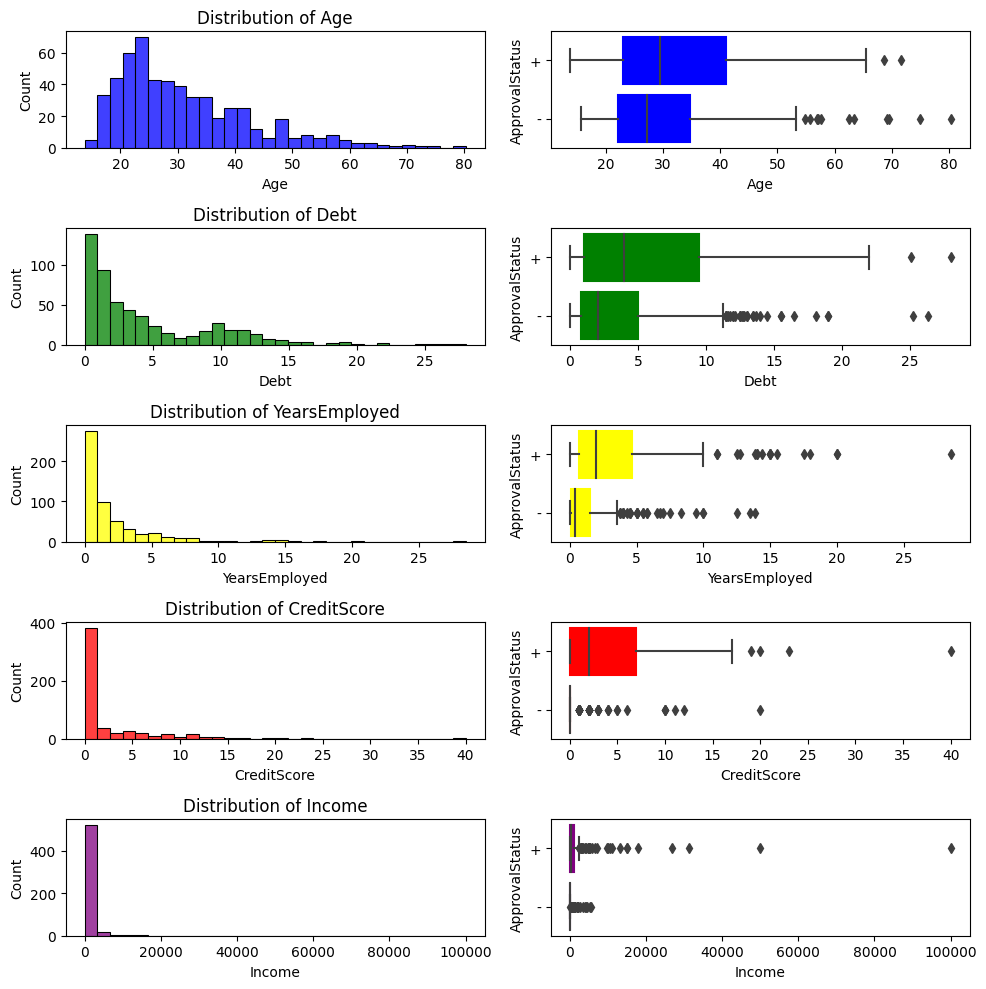

In [ ]:
plot_continous_data(X_train[contin_data_idx], y_train)

The charts above show that the continuous variables distributions are highly right skewed and different between each other. The `Age, Debt` features have the most amount of variance because the boxed are sparsely grouped about the mean, the `Income` features has the least amount of variance because the boxes are tightly grouped about the mean.

What's more, compare the features with `ApprovalStatus` we can found that the applicant whoes application are approved normally have: older age, more debt, longer working years, more creditscore and more income. However, at the same time, they also suffer a higher variance than those who doesn't get approved.

,Age,Debt,YearsEmployed,CreditScore,Income,ApprovalStatus
190,21.33000,10.500,3.000,0,0,+
528,55.75000,7.080,6.750,3,50,-
534,31.83000,2.500,7.500,0,0,-
547,23.92000,1.500,1.875,6,327,+
505,31.33000,19.500,7.000,16,5000,+
...,...,...,...,...,...,...
470,21.92000,11.665,0.085,0,5,-
52,37.42000,2.040,0.040,0,5800,+
515,31.11072,10.500,6.500,0,0,+
454,52.42000,1.500,3.750,0,350,-


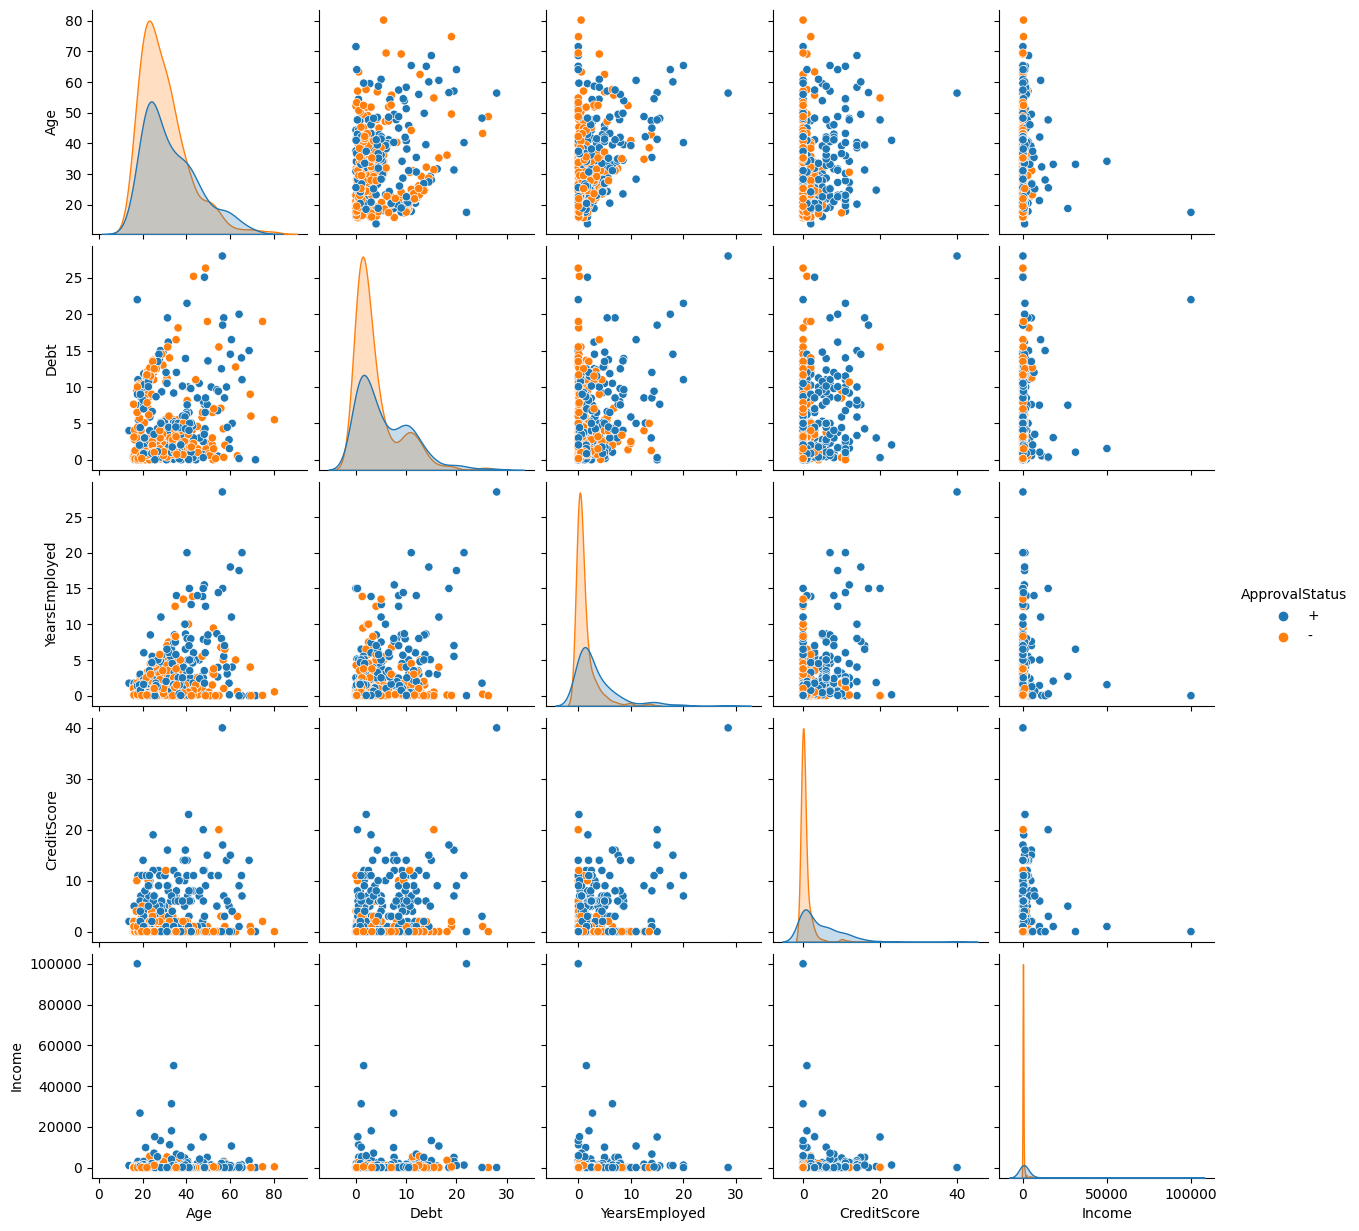

In [ ]:
num_data = pd.concat([X_train[contin_data_idx],y_train], axis=1)
display(num_data)
sns.pairplot(num_data, hue='ApprovalStatus')
plt.show()

#### (c) Data Scaling
In order to guarantee the training performance, we also need to scale the numerical values into certain range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[contin_data_idx] = scaler.fit_transform(X_train[contin_data_idx])
X_test[contin_data_idx] = scaler.transform(X_test[contin_data_idx])

### 1.2.2 Categorical-variable Features
#### (a) Missing Values Handling
In this part, we need to fill the missing value of non-numerical features, since the mean value of these variables cannot be calculated, we are going to impute these missing values with the most frequent values as present in the respective columns. This is good practice when it comes to imputing missing values for categorical data in general.

In [ ]:
for col in categor_data_idx.drop('ApprovalStatus'):
    X_train = X_train.fillna(X_train[col].value_counts().index[0])
    X_test = X_test.fillna(X_test[col].value_counts().index[0])

#### (b) Visualization

In [ ]:
def plot_categorical_data(categor_data, Y):
    Y = pd.DataFrame(Y, columns=['ApprovalStatus'])
    feature = categor_data
    cat_data = pd.concat([categor_data,Y],axis=1)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))
    axes = axes.flatten()
    for i, category in enumerate(feature):
        sns.countplot(data=cat_data, x=category, ax=axes[i], hue='ApprovalStatus')
        axes[i].set_xlabel(category)
        axes[i].set_ylabel('Count')
    plt.tight_layout()

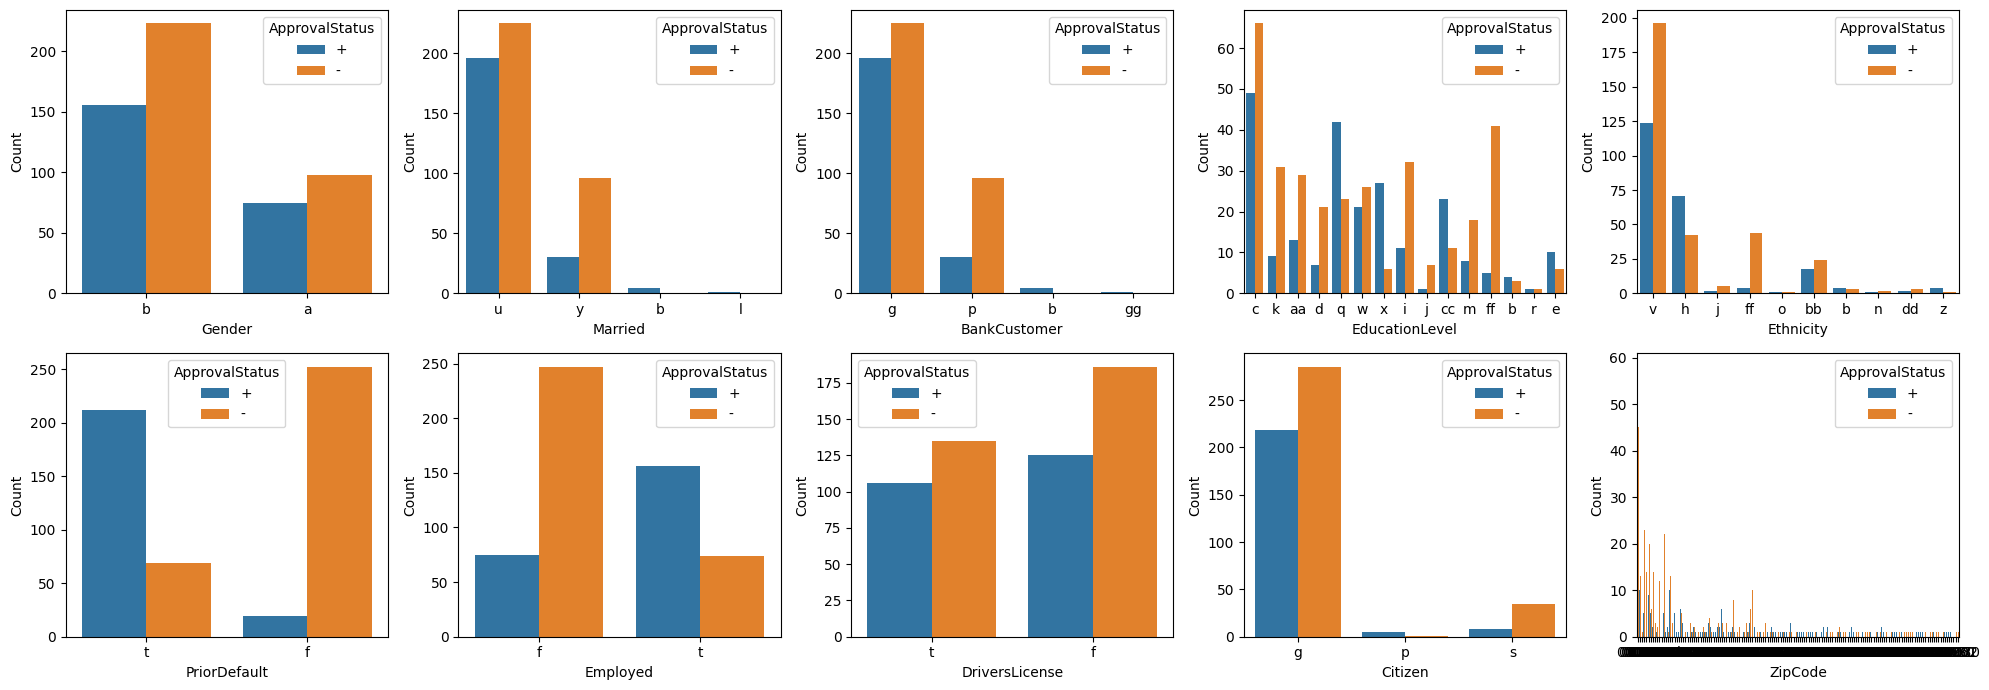

In [ ]:
plot_categorical_data(X_train[categor_data_idx.drop('ApprovalStatus')],y_train)

## 1.3 Correlation Test and Feature Discard
Then, we inspect the relationship between features (inputs and output) and discard the features that have low correlation with output since it will not benefit to the model training process.
### Continuous-variable Features

                    Age      Debt  YearsEmployed  CreditScore    Income
Age            1.000000  0.160701       0.390356     0.226465 -0.014343
Debt           0.160701  1.000000       0.296978     0.273009  0.132891
YearsEmployed  0.390356  0.296978       1.000000     0.413450  0.030477
CreditScore    0.226465  0.273009       0.413450     1.000000  0.048257
Income        -0.014343  0.132891       0.030477     0.048257  1.000000


<Axes: >

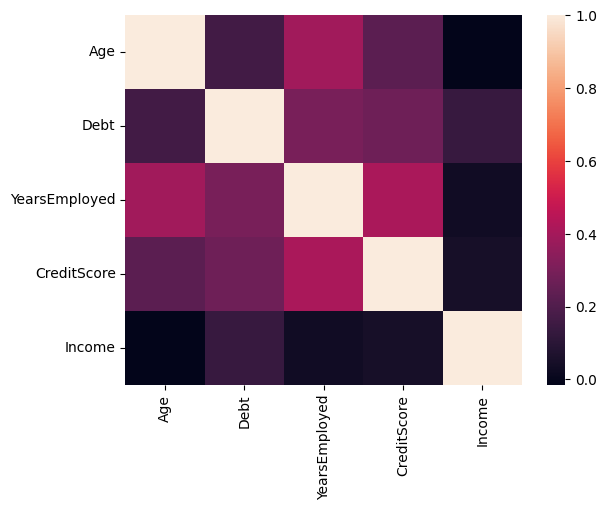

In [ ]:
contin_cor = X_train[contin_data_idx].corr()
print(contin_cor)
sns.heatmap(contin_cor)

To compute the correlation between continuous variables and categorical output, we use `Biserial Correlation` to measure it.

In [ ]:
from scipy.stats import pointbiserialr
def compute_contin_corr(contin_data, Y):
    Y = Y.map({'+' : 1, '-' : 0})
    feature = contin_data
    for i, category in enumerate(feature):
        result = pointbiserialr(Y,feature[category])
        print(result)

In [ ]:
compute_contin_corr(X_train[contin_data_idx], y_train)

SignificanceResult(statistic=0.13873426929220276, pvalue=0.0010833151973504691)
SignificanceResult(statistic=0.17584243394349006, pvalue=3.261277225637514e-05)
SignificanceResult(statistic=0.32501827875540223, pvalue=4.7813103727240735e-15)
SignificanceResult(statistic=0.44478618794229885, pvalue=3.5713546197895538e-28)
SignificanceResult(statistic=0.16919199267002194, pvalue=6.47113867928192e-05)


From the heatmap we can discover that for continuous-variable features, none of them are highly correlated with each other. Moreover, all of these features are highly correlated with output feature since the p-values are all very small. This indicates that all of these continuous variables are suitable for training.

### Categorical-variable Features

In [ ]:
from scipy.stats import chi2_contingency
def plot_categorical_corr(categor_data):

    feature = categor_data
    # Create an empty DataFrame to store chi-square values
    chi2_matrix = pd.DataFrame(index=feature.columns, columns=feature)



    for col1 in feature.columns:
        for col2 in feature.columns:
            if col1 == col2:
                chi2_matrix.loc[col1, col2] = 0.0
            else:
                contingency_table = pd.crosstab(feature[col1], feature[col2])
                _, p_value, _, _ = chi2_contingency(contingency_table)
                chi2_matrix.loc[col1, col2] = p_value
    display(chi2_matrix)

In [ ]:
plot_categorical_corr(X_train[categor_data_idx.drop('ApprovalStatus')])

,"(b, u, g, c, v, t, f, t, g, 00000)","(a, u, g, k, h, t, t, t, g, 00100)","(b, u, g, aa, v, t, f, t, g, 00523)","(b, u, g, d, h, t, t, f, g, 00200)","(b, u, g, c, v, t, t, f, g, 00000)","(a, u, g, q, h, f, f, f, g, 00280)","(b, y, p, w, v, t, t, t, g, 00120)","(a, y, p, x, h, t, t, f, g, 00000)","(b, u, g, c, v, f, f, f, g, 00300)","(b, y, p, k, h, t, f, f, g, 00180)",...,Gender,Married,BankCustomer,EducationLevel,Ethnicity,PriorDefault,Employed,DriversLicense,Citizen,ZipCode
Gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,5.665000e-01,5.665000e-01,1.023253e-09,1.433220e-03,5.286398e-01,2.083897e-02,0.455844,8.553959e-02,7.931622e-01
Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.665000e-01,0.000000e+00,0.000000e+00,1.067037e-50,1.083623e-109,7.853650e-04,5.709488e-05,0.215020,2.781316e-96,8.554727e-33
BankCustomer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.665000e-01,0.000000e+00,0.000000e+00,1.067037e-50,1.083623e-109,7.853650e-04,5.709488e-05,0.215020,2.781316e-96,8.554727e-33
EducationLevel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.023253e-09,1.067037e-50,1.067037e-50,0.000000e+00,0.000000e+00,1.014386e-07,3.174949e-07,0.102246,2.480132e-37,2.213641e-02
Ethnicity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.433220e-03,1.083623e-109,1.083623e-109,0.000000e+00,0.000000e+00,6.252748e-09,7.052835e-02,0.079751,7.342771e-45,2.121361e-03
PriorDefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.286398e-01,7.853650e-04,7.853650e-04,1.014386e-07,6.252748e-09,0.000000e+00,2.841592e-20,0.010973,1.529070e-03,1.902489e-01
Employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.083897e-02,5.709488e-05,5.709488e-05,3.174949e-07,7.052835e-02,2.841592e-20,0.000000e+00,1.000000,1.597070e-07,8.329126e-02
DriversLicense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.558445e-01,2.150197e-01,2.150197e-01,1.022456e-01,7.975068e-02,1.097269e-02,1.000000e+00,0.000000,3.248347e-01,3.032947e-01
Citizen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.553959e-02,2.781316e-96,2.781316e-96,2.480132e-37,7.342771e-45,1.529070e-03,1.597070e-07,0.324835,0.000000e+00,1.740911e-03
ZipCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.931622e-01,8.554727e-33,8.554727e-33,2.213641e-02,2.121361e-03,1.902489e-01,8.329126e-02,0.303295,1.740911e-03,0.000000e+00


Based on the chi-square matrix, we can discover that the `Gender, DriversLicense, ZipCode` features have relative high p-values with most of other features, which means they do not have strong relationship with other features.

In [ ]:
def compute_categ_corr(categor_data):
    feature = categor_data.drop(['ApprovalStatus'], axis=1)
    for i, category in enumerate(feature):
        contingency_table = pd.crosstab(feature[category], categor_data['ApprovalStatus'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(category,p_value)

In [ ]:
Y = pd.DataFrame(y_train, columns=['ApprovalStatus'])
cat_data = pd.concat([X_train[categor_data_idx.drop('ApprovalStatus')],Y],axis=1)
compute_categ_corr(cat_data)

Gender 0.6956482433490574
Married 4.34383510597917e-06
BankCustomer 4.34383510597917e-06
EducationLevel 1.4257931883226264e-12
Ethnicity 2.3410516355101748e-07
PriorDefault 4.471584228373263e-59
Employed 3.4226268728444267e-25
DriversLicense 0.4188781537069455
Citizen 0.0008049374272952941
ZipCode 0.011911728402362768



Based on the result, we can find that `Gender, DriversLicense` features are not correlated to output features (p-values are high), thus, we need to discard them.

In [ ]:
X_train_clip = X_train.drop(['Gender','DriversLicense', 'ZipCode'], axis=1)
X_test_clip = X_test.drop(['Gender','DriversLicense', 'ZipCode'], axis=1)
display(X_train_clip)

,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income
190,0.113985,0.375000,u,g,c,v,0.105263,t,f,0.000,g,0.00000
528,0.631579,0.252857,u,g,k,h,0.236842,t,t,0.075,g,0.00050
534,0.271880,0.089286,u,g,aa,v,0.263158,t,f,0.000,g,0.00000
547,0.152932,0.053571,u,g,d,h,0.065789,t,t,0.150,g,0.00327
505,0.264361,0.696429,u,g,c,v,0.245614,t,t,0.400,g,0.05000
...,...,...,...,...,...,...,...,...,...,...,...,...
470,0.122857,0.416607,u,g,k,h,0.002982,f,f,0.000,g,0.00005
52,0.355940,0.072857,u,g,w,v,0.001404,t,f,0.000,g,0.05800
515,0.261063,0.375000,u,g,x,v,0.228070,t,f,0.000,g,0.00000
454,0.581504,0.053571,u,g,d,v,0.131579,f,f,0.000,g,0.00350


## 1.4 Data Transformation
After this, we should transform the character symbols to numerical values since character are not meaningful and cannot be used in classification and logistic regression models later. For transformation, we use `get_dummies()` methods for pandas.

In [ ]:
X_train_trans_clip = pd.get_dummies(X_train_clip)
X_test_trans_clip = pd.get_dummies(X_test_clip)
# Reindex the columns of the test set aligning with the train set
X_test_trans_clip = X_test_trans_clip.reindex(columns=X_train_trans_clip.columns, fill_value=0)
# display(X_train_trans)
y_train = y_train.map({'+' : 1, '-' : 0})
y_test = y_test.map({'+' : 1, '-' : 0})
display(X_train_trans_clip )

,Age,Debt,YearsEmployed,CreditScore,Income,Married_b,Married_l,Married_u,Married_y,BankCustomer_b,...,Ethnicity_o,Ethnicity_v,Ethnicity_z,PriorDefault_f,PriorDefault_t,Employed_f,Employed_t,Citizen_g,Citizen_p,Citizen_s
190,0.113985,0.375000,0.105263,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
528,0.631579,0.252857,0.236842,0.075,0.00050,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
534,0.271880,0.089286,0.263158,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
547,0.152932,0.053571,0.065789,0.150,0.00327,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
505,0.264361,0.696429,0.245614,0.400,0.05000,0,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,0.122857,0.416607,0.002982,0.000,0.00005,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
52,0.355940,0.072857,0.001404,0.000,0.05800,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
515,0.261063,0.375000,0.228070,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
454,0.581504,0.053571,0.131579,0.000,0.00350,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0


In [ ]:
X_train = X_train_trans_clip
X_test = X_test_trans_clip

display(X_test)
display(X_train)

,Age,Debt,YearsEmployed,CreditScore,Income,Married_b,Married_l,Married_u,Married_y,BankCustomer_b,...,Ethnicity_o,Ethnicity_v,Ethnicity_z,PriorDefault_f,PriorDefault_t,Employed_f,Employed_t,Citizen_g,Citizen_p,Citizen_s
70,0.279398,0.267857,0.055614,0.000,0.00000,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
330,0.100301,0.000000,0.000000,0.000,0.00000,1,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
577,0.171729,0.214286,0.035088,0.075,0.00000,0,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0
594,0.374737,0.007500,0.002982,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
636,0.408571,0.017857,0.017544,0.000,0.00000,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.209323,0.072857,0.008772,0.000,0.00050,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
132,0.506316,0.285714,0.228070,0.150,0.51100,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
434,0.674135,0.096786,0.084737,0.000,0.00000,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
134,0.284511,0.196429,0.192982,0.300,0.01000,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0


,Age,Debt,YearsEmployed,CreditScore,Income,Married_b,Married_l,Married_u,Married_y,BankCustomer_b,...,Ethnicity_o,Ethnicity_v,Ethnicity_z,PriorDefault_f,PriorDefault_t,Employed_f,Employed_t,Citizen_g,Citizen_p,Citizen_s
190,0.113985,0.375000,0.105263,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
528,0.631579,0.252857,0.236842,0.075,0.00050,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
534,0.271880,0.089286,0.263158,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
547,0.152932,0.053571,0.065789,0.150,0.00327,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
505,0.264361,0.696429,0.245614,0.400,0.05000,0,0,1,0,0,...,0,1,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,0.122857,0.416607,0.002982,0.000,0.00005,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
52,0.355940,0.072857,0.001404,0.000,0.05800,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
515,0.261063,0.375000,0.228070,0.000,0.00000,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
454,0.581504,0.053571,0.131579,0.000,0.00350,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0


# 2. Training Models


In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")


## 2.1 Classifier Performance Evaluation

We want to train the data with different model and then evaluated on a dataset (`X_test`, `y_test`). The evaluated metrics include accuracy, recall, F1 score, and ROC AUC score. Each model is added to a list with its corresponding name and configuration settings.

### Models Included

- **K-Nearest Neighbors** with distance weighting and 'ball_tree' algorithm
- **Gaussian Naive Bayes**
- **Bernoulli Naive Bayes**
- **Decision Trees** with 'gini' index and 'entropy' as the criteria
- **Support Vector Machine** with a high regularization factor (C=100,000)
- **AdaBoost** with a learning rate of 2 and 100 estimators, using a `RandomForestClassifier` as the base estimator
- **Logistic Regression** with a high regularization (C=10,000), a stringent tolerance for convergence, and 'sag' solver for large datasets
- **Gradient Boosting Decision Tree** with a depth of 6 and 100 estimators
- **Random Forest** with both 'gini' and 'entropy' criteria
- **XGBoost**
- **Multilayer Perceptron** with L2 penalty term (alpha=0.01)
- **Stochastic Gradient Descent Classifier** also with an L2 penalty term (alpha=0.01)

For each classifier in the list, we want to
1. Fit the model to the training data.
2. Predict the outcomes on the test data.
3. Calculate the evaluation metrics.
4. Log the metrics in a Pandas DataFrame.

In [ ]:
model = []
model.append(('KNN', KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='ball_tree')))
model.append(('GaussianNB',GaussianNB()))
model.append(('BernoulliNB',BernoulliNB()))
model.append(('DecisionTree gini',DecisionTreeClassifier(criterion='gini',random_state=seed)))
model.append(('DecisionTreeEntropy',DecisionTreeClassifier(criterion='entropy',random_state=seed)))
model.append(('SVM',SVC(C=100000,random_state=seed)))
model.append(('AdaBoost',AdaBoostClassifier(learning_rate=2,n_estimators=100,estimator=RandomForestClassifier(),random_state=seed)))
model.append(('Logistic',LogisticRegression(C=10000,tol=1e-10,solver="sag",max_iter=10000,random_state=seed)))
model.append(('GBDT',GradientBoostingClassifier(max_depth=6,n_estimators=100,random_state=seed)))
model.append(('RandomForest entropy',RandomForestClassifier(criterion='gini',random_state=seed)))
model.append(('RandomForest gini',RandomForestClassifier(criterion='entropy',random_state=seed)))
model.append(('XGBoster', XGBClassifier(random_state=seed)))
model.append(('MLPClassifer', MLPClassifier(alpha=0.01, max_iter=10000,random_state=seed)))
model.append(('SGDClassifier', SGDClassifier(alpha=0.01, max_iter=10000,random_state=seed)))

# Y=DataFrame()
log_cols=["Classifier", "Accuracy", "Recall", "F1", "ROC"]
log = pd.DataFrame(columns=log_cols)

for clf_name, clf in model:
    clf.fit(X_train, y_train) # Training
    Y_pred = clf.predict(X_test) # Prediction


    acc = accuracy_score(y_test, Y_pred)
    rec = recall_score(y_test, Y_pred)
    f1 = f1_score(y_test, Y_pred)
    roc_auc = roc_auc_score(y_test, Y_pred)

    log_entry = pd.DataFrame([[clf_name, acc*100, rec*100, f1, roc_auc]], columns=log_cols)
    print("{} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\".format(clf_name, acc*100, rec*100, f1 * 100, roc_auc))
    log = pd.concat([log, log_entry])


KNN & 84.058 & 78.947 & 84.507 & 0.846 \\
GaussianNB & 53.623 & 19.737 & 31.915 & 0.574 \\
BernoulliNB & 85.507 & 78.947 & 85.714 & 0.862 \\
DecisionTree gini & 84.058 & 84.211 & 85.333 & 0.840 \\
DecisionTreeEntropy & 84.058 & 82.895 & 85.135 & 0.842 \\
SVM & 81.159 & 78.947 & 82.192 & 0.814 \\
AdaBoost & 86.957 & 85.526 & 87.838 & 0.871 \\
Logistic & 84.058 & 81.579 & 84.932 & 0.843 \\
GBDT & 84.058 & 85.526 & 85.526 & 0.839 \\
RandomForest entropy & 87.681 & 86.842 & 88.591 & 0.878 \\
RandomForest gini & 87.681 & 85.526 & 88.435 & 0.879 \\
XGBoster & 84.058 & 84.211 & 85.333 & 0.840 \\
MLPClassifer & 84.783 & 81.579 & 85.517 & 0.851 \\
SGDClassifier & 89.855 & 94.737 & 91.139 & 0.893 \\


,Classifier,Accuracy,Recall,F1,ROC
0,GaussianNB,53.623188,19.736842,0.319149,0.574491
0,SVM,81.159420,78.947368,0.821918,0.814092
0,KNN,84.057971,78.947368,0.845070,0.846350
0,DecisionTree gini,84.057971,84.210526,0.853333,0.840407
0,DecisionTreeEntropy,84.057971,82.894737,0.851351,0.841893
0,Logistic,84.057971,81.578947,0.849315,0.843379
0,GBDT,84.057971,85.526316,0.855263,0.838922
0,XGBoster,84.057971,84.210526,0.853333,0.840407
0,MLPClassifer,84.782609,81.578947,0.855172,0.851443
0,BernoulliNB,85.507246,78.947368,0.857143,0.862479


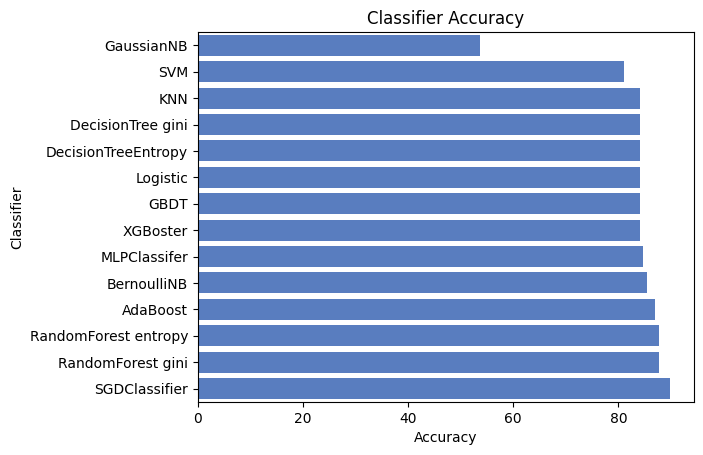

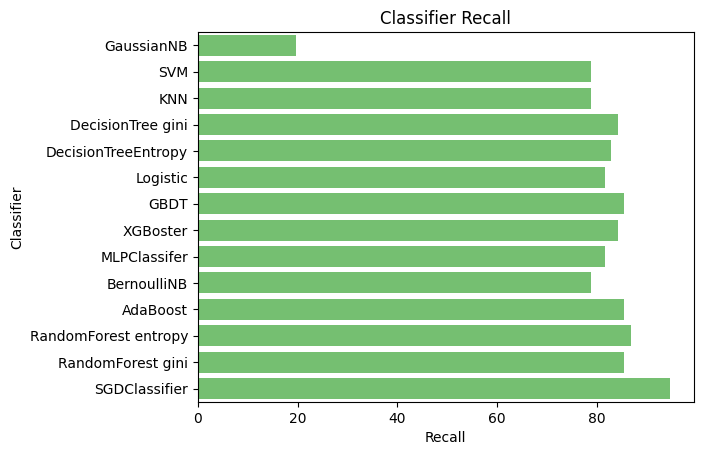

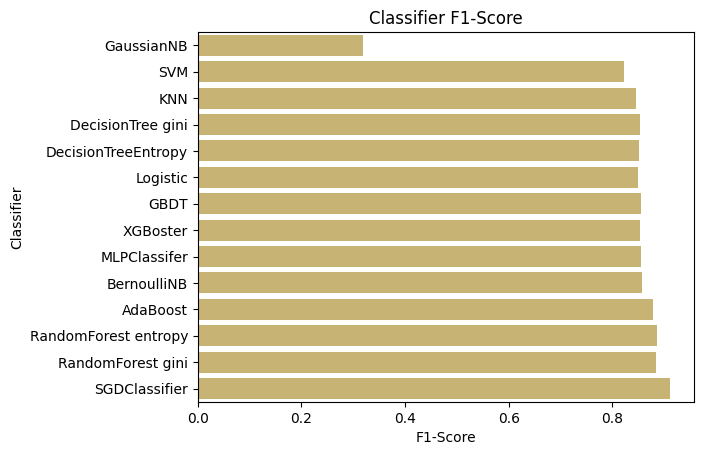

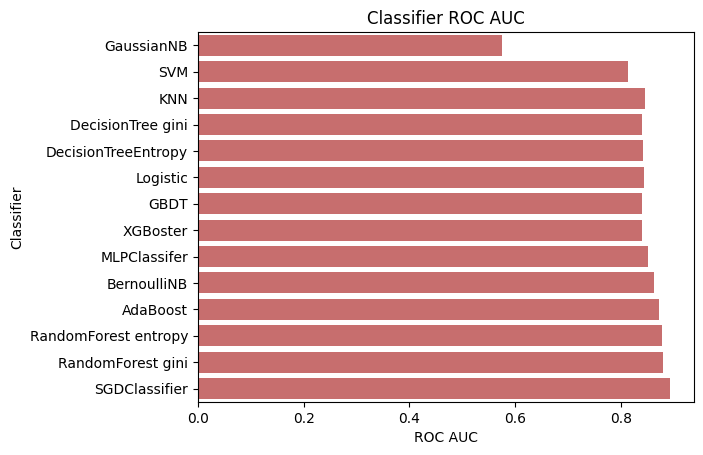

In [ ]:

sorted_log = log.sort_values(by=["Accuracy"])
display(sorted_log)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=sorted_log, color="b")

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=sorted_log, color="g")

plt.xlabel('Recall')
plt.title('Classifier Recall')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=sorted_log, color="y")

plt.xlabel('F1-Score')
plt.title('Classifier F1-Score')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='ROC', y='Classifier', data=sorted_log, color="r")

plt.xlabel('ROC AUC')
plt.title('Classifier ROC AUC')
plt.show()

## 2.2 Stochastic Gradient Descent Classifer

Select the top classifier for further finetuning, where SGDClassifier is clearly better than others in terms of all metrics.
In this part we will use grid search to choose the values of the hyperparameters of Stochastic Gradient Descent.  Pass these parameters to the contructor of the logistic regression classifier:
+ `solver`: `SGDClassifier`
+ `get_param_order(param_grid)`:
Identifies the keys in the parameter grid that have exactly three values and the remaining keys. Returns a list containing the first key with three values, the remaining key, and the second key with three values.
+ `unpack_gridsearch(gs, param_grid, folds)`:
 Extracts the cross-validation results from the GridSearchCV object and organizes them into a dictionary. The keys  the values of the first parameter in the parameter grid, the values are dataframes containing the mean test accuracy and mean test balanced accuracy for each value of the second parameter.
+ `plot_grid_result(X, param_grid, log=True)`:
 plot on a log scale as input.

Then fit the model using the training data.

In [ ]:
def get_param_order(param_grid):
    param0 = [key for key, value in param_grid.items() if len(value) == 3]
    print("param0",param0)
    param1 = param_grid.keys() - param0
    print("param1",param0,param1)
    return [param0[0],param1.pop(),param0[1]]

def unpack_gridsearch(gs,param_grid,folds):

    result = gs.cv_results_

    cols = ['mean_test_accuracy','mean_test_balanced_accuracy']

    param_order = get_param_order(param_grid)
    print("param_order",param_order)
    f0 = 'param_{}'.format(param_order[0])
    f1 = 'param_{}'.format('alpha')

    f0vals = param_grid[param_order[0]]
    f1vals = param_grid['alpha']

    X = dict.fromkeys(f0vals)

    for f0val in f0vals:
        X[f0val] = pd.DataFrame(index=f1vals,columns=cols,dtype=float)

    for f0val in f0vals:
        for f1val in f1vals:
            ind = (result[f0]==f0val) & (result[f1]==f1val)
            for col in cols:
                X[f0val].loc[f1val,col] = float(result[col][ind][0])

    return X, gs.best_params_, gs.best_estimator_, gs.best_score_


def plot_grid_result(X,param_grid,log=True):
# Get the order of parameters in the grid
    param_order = get_param_order(param_grid)
    cols = ['mean_test_accuracy', 'mean_test_balanced_accuracy']
    labels = ['accuracy', 'balanced_accuracy']
    colors = ['r','b']
    linestyles = ['-', '--', '-.', ':']

    f0vals = param_grid[param_order[0]]
    losses=param_grid[param_order[1]]
    # print("f0vals",f0vals)
    # print("col",cols)
    # print("losses",losses)
    plt.figure(figsize=(14,7))
    # print("X21",X[f0vals[1]][cols[0]].shape,X[f0vals[1]][cols[0]])
    for f0ind, f0val in enumerate(f0vals):
        for c, col in enumerate(cols):
            # data = X[f0val, col]
            # print("f0val",f0val)
            # print("col",col)
            # If log is True, plot on a log scale. Otherwise, plot on a linear scale.
            if log:
                plt.semilogx(X[f0val][col],color=colors[c],marker='o',linestyle=linestyles[f0ind],label='{} {}'.format(f0val,labels[c]))
            else:
                plt.plot(X[f0val][col],color=colors[c],marker='o',linestyle=linestyles[f0ind],label='{} {}'.format(f0val,labels[c]))

    plt.legend(fontsize=14)
    plt.grid(':')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

## 2.3. Hyperparameter tuning with grid search

Run grid search (see documentation here: [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) with 3-fold cross validation. The parameters to search over are:

+ the regularization function `penalty`.
+ the regularization weight `C`.
+ the Number of iterations with no improvement to wait before stopping fitting `n_iter_no_change`.
+ the loss function to be used `loss`.
+ The Elastic Net mixing parameter `    'l1_ratio' : np.linspace(0.5, 0.8, 20),
`.
```python
param_grid = {
    'penalty' : ["l1","l2", "elasticnet"],
    'alpha' : np.logspace(-4, -2, 20),
    'l1_ratio' : np.linspace(0.5, 0.8, 20),
    'n_iter_no_change' : [8,9,10],
    'loss': ["hinge", "log_loss", "perceptron"],
}

param0 ['penalty', 'loss']
param1 ['penalty', 'loss'] {'l1_ratio', 'alpha', 'n_iter_no_change'}
param_order ['penalty', 'l1_ratio', 'loss']
param0 ['penalty', 'loss']
param1 ['penalty', 'loss'] {'l1_ratio', 'alpha', 'n_iter_no_change'}


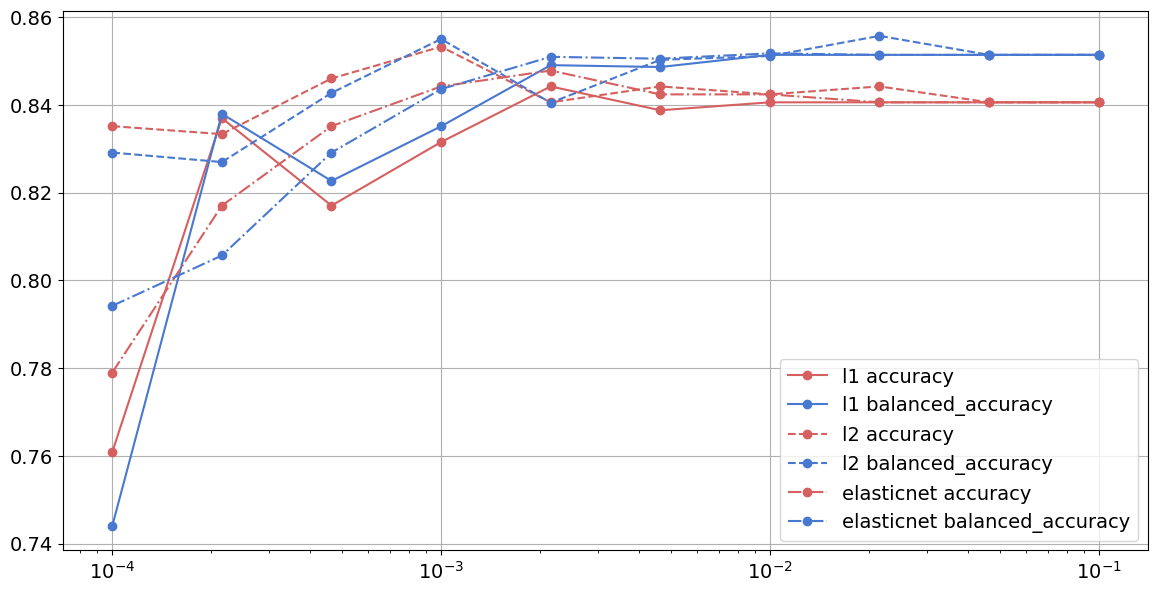

best_model SGDClassifier(alpha=0.004641588833612777, l1_ratio=0.7736842105263158,
              loss='log_loss', n_iter_no_change=4)
best_score 0.8795161225067766
Best hyperparameters: {'alpha': 0.004641588833612777, 'l1_ratio': 0.7736842105263158, 'loss': 'log_loss', 'n_iter_no_change': 4, 'penalty': 'l2'}
Accuracy of the best model: 0.8768115942028986
Balanced accuracy of the best model: 0.8747877758913413


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
cvfolds = 3
model = SGDClassifier()
param_grid = {
    'penalty' : ["l1","l2", "elasticnet"],
    'alpha' : np.logspace(-4, -1, 10),
    'l1_ratio' : np.linspace(0.1, 0.9, 20),
    'n_iter_no_change' : [4,5,6,7,8,9],
    'loss': ["hinge", "log_loss", "perceptron"],

}
gs = GridSearchCV(estimator= model, param_grid=param_grid, scoring=['accuracy', 'balanced_accuracy'],cv=cvfolds, refit='balanced_accuracy')
gs = gs.fit(X_train, y_train)

result, best_params, best_model, best_score = unpack_gridsearch(gs, param_grid, cvfolds)

# 5. Plot the result with `lab6.plot_grid_result`
plot_grid_result(result, param_grid)
print("best_model",best_model)
print("best_score",best_score)

best_model.fit(X_train, y_train)
best_model_preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, best_model_preds)
balanced_accuracy = balanced_accuracy_score(y_test, best_model_preds)

# Print the best hyperparameters and the accuracy of the best model
print(f"Best hyperparameters: {best_params}")
print(f"Accuracy of the best model: {accuracy}")
print(f"Balanced accuracy of the best model: {balanced_accuracy}")

According to https://stackoverflow.com/questions/68952967/the-test-accuracy-score-is-higher-than-the-best-score-in-gridsearchcv, the bestscore in the train dataset does not ensure a better performance in the test dataset. Although the test score in the test dataset is lower than the train dataset, we believe our tuning has reached the best outcomes.